# Wiseanalytics : Sales Forecasting 

# PART 1 : Data Processing and Feature Engineering 

## Import Libraries and Load Data


In [1]:
# Import necessary libraries for data handling, visualization, and modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load datasets

train = pd.read_csv("C:\\Users\\vaish\\Downloads\\store_forecasting_data (1)\\store_forecasting_data\\train.csv")
test = pd.read_csv("C:\\Users\\vaish\\Downloads\\store_forecasting_data (1)\\store_forecasting_data\\test.csv")
stores = pd.read_csv("C:\\Users\\vaish\\Downloads\\store_forecasting_data (1)\\store_forecasting_data\\stores.csv")
oil = pd.read_csv("C:\\Users\\vaish\\Downloads\\store_forecasting_data (1)\\store_forecasting_data\\oil.csv")
holidays = pd.read_csv("C:\\Users\\vaish\\Downloads\\store_forecasting_data (1)\\store_forecasting_data\\holidays_events.csv")

##### We import core libraries for data analysis (pandas, numpy), visualization (matplotlib, seaborn), machine learning models (scikit-learn, xgboost, RandomForest), and deep learning (TensorFlow/Keras).

##### We read the sales, store, oil, and holiday datasets which will later be merged for modeling.



In [2]:
# Display basic info
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
print("Stores Shape:", stores.shape)
print("Oil Shape:", oil.shape)
print("Holidays Shape:", holidays.shape)

Train Shape: (3000888, 6)
Test Shape: (28512, 5)
Stores Shape: (54, 5)
Oil Shape: (1218, 2)
Holidays Shape: (350, 6)


## Data Cleaning

In [3]:
# Convert date columns
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

# Fill missing oil prices
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate()

# Merge store information into the main dataset
train = train.merge(stores, on='store_nbr', how='left', suffixes=('', '_store'))

# Merge oil prices into the main dataset
train = train.merge(oil, on='date', how='left')

# Filter non-transferred holidays and clean up holiday events
holidays_filtered = holidays[holidays['transferred'] == False]

# Sort to prioritize National holidays
holiday_priority = {'National': 0, 'Regional': 1, 'Local': 2}
holidays_filtered['priority'] = holidays_filtered['locale'].map(holiday_priority)

# Keep the most important event per day
holidays_cleaned = holidays_filtered.sort_values('priority').drop_duplicates(subset='date')

# Rename the 'type' column in holidays_cleaned to avoid conflicts during merge
holidays_cleaned.rename(columns={'type': 'holiday_type'}, inplace=True)

# Merge holidays into the main dataset with a custom suffix
train = train.merge(holidays_cleaned[['date', 'holiday_type']], on='date', how='left', suffixes=('', '_holiday'))


##### Dates are standardized and missing oil prices are filled using linear interpolation to maintain continuity in external factors.

##### We enrich the training data with store attributes, oil prices, and cleaned holiday information for better context.

## Feature Engineering


In [4]:
# Time-based features
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek
train['is_weekend'] = train['day_of_week'].isin([5,6]).astype(int)
train['is_december'] = (train['month'] == 12).astype(int)


# Event-based features
# Paydays
train['is_payday'] = train['date'].dt.day.isin([15, train['date'].dt.days_in_month])

# Earthquake impact (April 16, 2016)
train['earthquake'] = (train['date'] == '2016-04-16').astype(int)

# Holiday binary flag
train['is_holiday'] = train['type'].notnull().astype(int)


# Rolling statistics
train.sort_values(by=['store_nbr', 'family', 'date'], inplace=True)

# Lag features
train['lag_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(7)
train['lag_30'] = train.groupby(['store_nbr', 'family'])['sales'].shift(30)

# Rolling features
train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1).rolling(7).mean())
train['rolling_std_7'] = train.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1).rolling(7).std())


# Store-specific aggregations
# Avg sales per store type
store_avg = train.groupby('store_nbr')['sales'].mean().reset_index().rename(columns={'sales': 'avg_sales_store'})
train = train.merge(store_avg, on='store_nbr', how='left')

# Top-selling families per cluster
top_families = train.groupby(['cluster', 'family'])['sales'].sum().reset_index()
top_families = top_families.sort_values(['cluster', 'sales'], ascending=[True, False])
top_families['rank'] = top_families.groupby('cluster')['sales'].rank(method='first', ascending=False)
train = train.merge(top_families[['cluster', 'family', 'rank']], on=['cluster', 'family'], how='left')


##### We generate features like weekday, weekend, and December flag to capture calendar patterns.

##### Features like paydays, earthquake event, and holiday flag help capture abnormal sales behavior.

##### These features reflect short-term and long-term trends which are crucial for forecasting.

##### Store averages and cluster-based top family rankings help capture macro-level trends in stores and customer preferences.



## Exploratory Data Analysis (EDA)

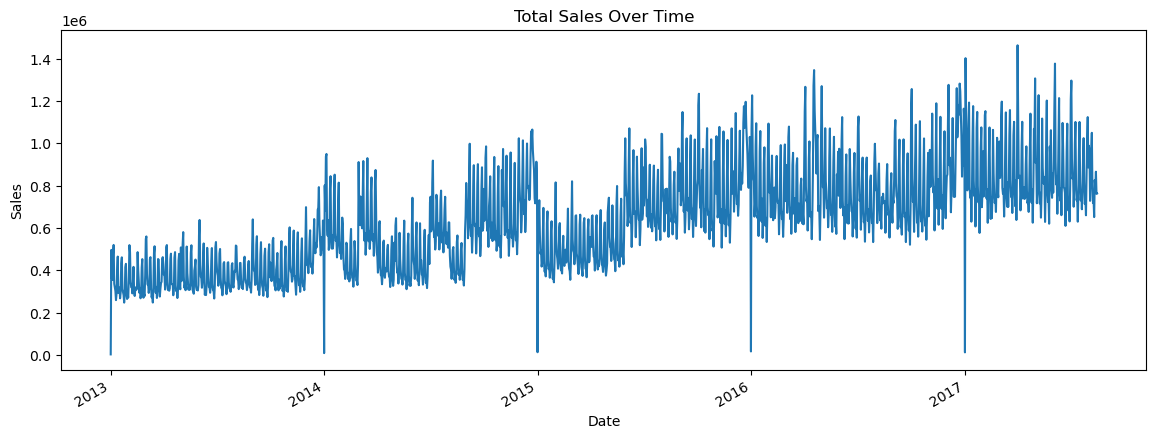

In [5]:
# Sales over Time

daily_sales = train.groupby('date')['sales'].sum()
plt.figure(figsize=(14,5))
daily_sales.plot(title="Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()



##### We visualize sales trends over time to identify seasonality, spikes, and dips.



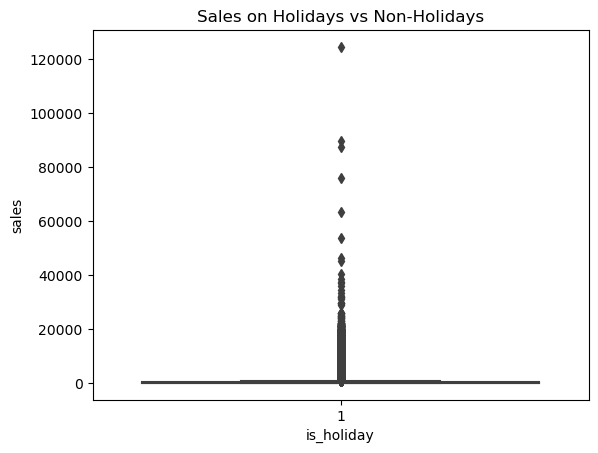

In [6]:
#  Sales Before/After Holidays

sns.boxplot(data=train, x='is_holiday', y='sales')
plt.title("Sales on Holidays vs Non-Holidays")
plt.show()



##### This plot shows how sales differ during holidays compared to regular days.



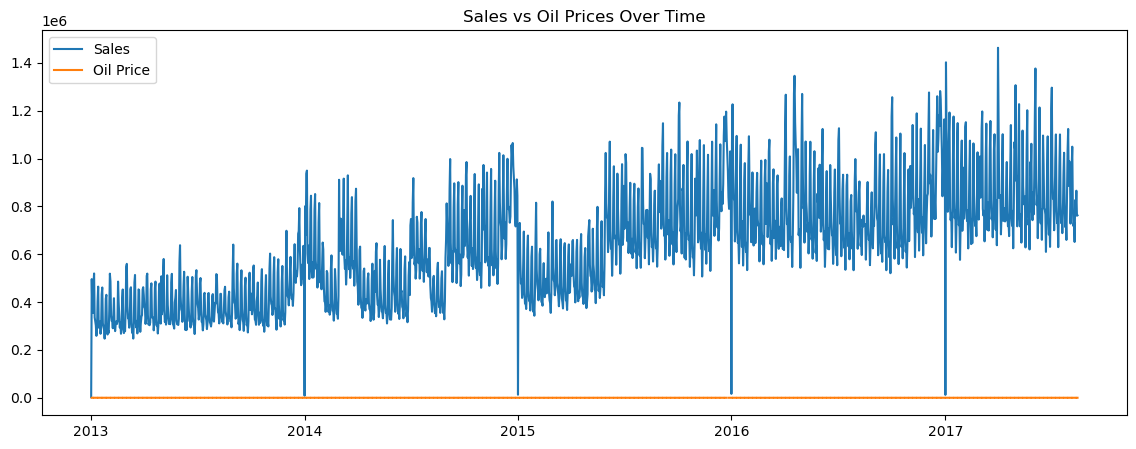

In [7]:
# Oil Price vs Sales

plt.figure(figsize=(14,5))
plt.plot(train.groupby('date')['sales'].sum(), label='Sales')
plt.plot(train.groupby('date')['dcoilwtico'].mean(), label='Oil Price')
plt.legend()
plt.title("Sales vs Oil Prices Over Time")
plt.show()


##### Correlates oil price trends with overall sales to evaluate external economic influence.

# PART 2 : Model Training, Forecasting & Evaluation

## Prepare Data for Modeling

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Drop rows with missing values due to lag/rolling
model_data = train.dropna()

# Feature columns
features = ['day', 'month', 'year', 'day_of_week', 'is_weekend', 'is_december',
            'is_payday', 'earthquake', 'is_holiday', 'lag_7', 'lag_30',
            'rolling_mean_7', 'rolling_std_7', 'avg_sales_store', 'rank']

X = model_data[features]
y = model_data['sales']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)


##### We drop rows with nulls due to lags/rolls and split data for training and validation.

## Baseline Model (Naive)

In [9]:
y_pred_baseline = X_valid['lag_7']

#####  The 7-day lag is used as a simple baseline forecast.



## Random Forest Regressor

In [10]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)


## XGBoost

In [11]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_valid)


##### These tree-based models handle non-linear patterns and interactions well.



In [12]:
# Scale features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape for LSTM: [samples, time_steps, features]
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train/Validation split
X_train_lstm, X_valid_lstm = X_lstm[:-2000], X_lstm[-2000:]
y_train_lstm, y_valid_lstm = y_scaled[:-2000], y_scaled[-2000:]

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(1, X_lstm.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# Train model
model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64,
          validation_data=(X_valid_lstm, y_valid_lstm), verbose=1)

# Predict and inverse transform
y_pred_lstm = model.predict(X_valid_lstm)
y_pred_lstm_inv = scaler_y.inverse_transform(y_pred_lstm)
y_valid_lstm_inv = scaler_y.inverse_transform(y_valid_lstm)



Epoch 1/10
4731/4731 [==============================] - 21s 4ms/step - loss: 2.6908e-05 - val_loss: 9.5898e-07
Epoch 2/10
4731/4731 [==============================] - 18s 4ms/step - loss: 2.1384e-05 - val_loss: 7.9428e-07
Epoch 3/10
4731/4731 [==============================] - 18s 4ms/step - loss: 2.0644e-05 - val_loss: 2.2131e-06
Epoch 4/10
4731/4731 [==============================] - 17s 4ms/step - loss: 2.0629e-05 - val_loss: 5.3038e-07
Epoch 5/10
4731/4731 [==============================] - 18s 4ms/step - loss: 2.0205e-05 - val_loss: 3.6923e-07
Epoch 6/10
4731/4731 [==============================] - 18s 4ms/step - loss: 1.9770e-05 - val_loss: 7.0130e-07
Epoch 7/10
4731/4731 [==============================] - 17s 4ms/step - loss: 1.9736e-05 - val_loss: 3.1991e-07
Epoch 8/10
4731/4731 [==============================] - 18s 4ms/step - loss: 1.9364e-05 - val_loss: 5.7673e-07
Epoch 9/10
4731/4731 [==============================] - 18s 4ms/step - loss: 1.9423e-05 - val_loss: 3.3825e-07
E

## Evaluation Function



In [13]:
def evaluate_model(y_true, y_pred, name="Model"):
    print(f"📌 {name}")
    print(f"RMSE: {mean_squared_error(y_true, y_pred, squared=False):.2f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred)*100:.2f}%")
    print(f"R² Score: {r2_score(y_true, y_pred):.3f}")
    print("-"*40)

evaluate_model(y_valid, y_pred_baseline, "Naive Forecast")
evaluate_model(y_valid, y_pred_rf, "Random Forest")
evaluate_model(y_valid, y_pred_xgb, "XGBoost")
evaluate_model(y_valid_lstm_inv, y_pred_lstm_inv, "LSTM")

📌 Naive Forecast
RMSE: 933.30
MAPE: 6432367504495697920.00%
R² Score: 0.727
----------------------------------------
📌 Random Forest
RMSE: 629.44
MAPE: 2621926159152530944.00%
R² Score: 0.876
----------------------------------------
📌 XGBoost
RMSE: 600.76
MAPE: 1815871497080480768.00%
R² Score: 0.887
----------------------------------------
📌 LSTM
RMSE: 118.10
MAPE: 10958593713181294592.00%
R² Score: 0.346
----------------------------------------


##### We use RMSE, MAPE, and R² to compare model performances.



## Actual vs Predicted Plot

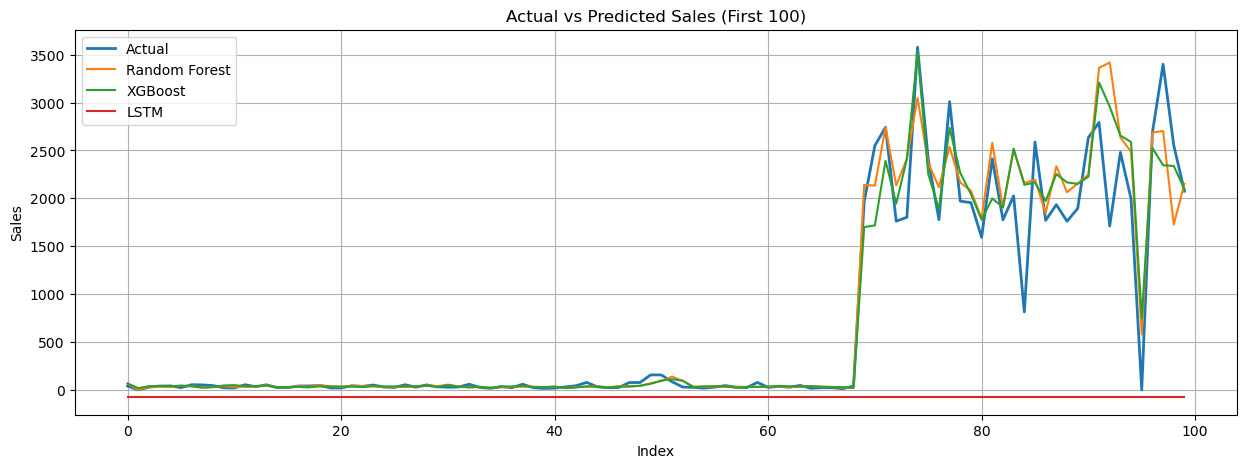

In [14]:
## Actual vs Predicted Comparison Plot (All Models)

plt.figure(figsize=(15,5))
plt.plot(y_valid.values[:100], label="Actual", linewidth=2)
plt.plot(y_pred_rf[:100], label="Random Forest")
plt.plot(y_pred_xgb[:100], label="XGBoost")
plt.plot(y_pred_lstm_inv[:100], label="LSTM")
plt.legend()
plt.title("Actual vs Predicted Sales (First 100)")
plt.xlabel("Index")
plt.ylabel("Sales")
plt.grid(True)
plt.show()



##### A visual check of prediction accuracy over the first 100 days of the validation period.

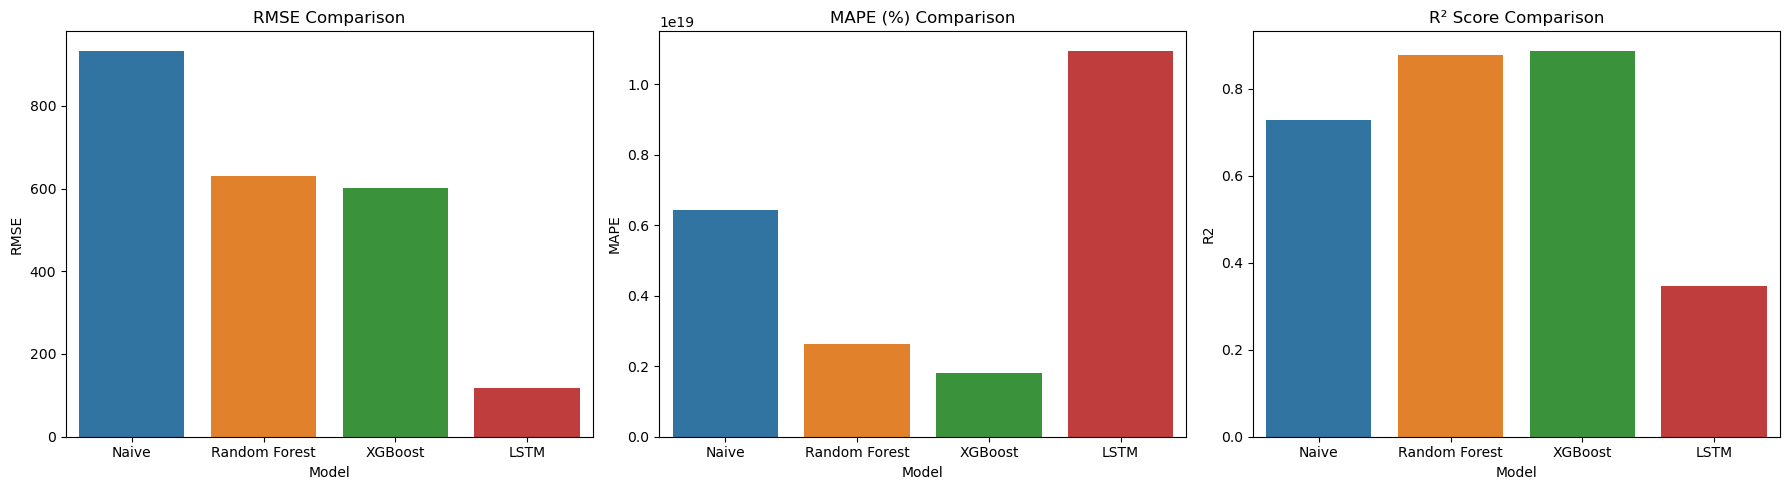

In [15]:
# Collect metrics for all models
results = {
    "Model": ["Naive", "Random Forest", "XGBoost", "LSTM"],
    "RMSE": [
        mean_squared_error(y_valid, y_pred_baseline, squared=False),
        mean_squared_error(y_valid, y_pred_rf, squared=False),
        mean_squared_error(y_valid, y_pred_xgb, squared=False),
        mean_squared_error(y_valid_lstm_inv, y_pred_lstm_inv, squared=False)
    ],
    "MAPE": [
        mean_absolute_percentage_error(y_valid, y_pred_baseline)*100,
        mean_absolute_percentage_error(y_valid, y_pred_rf)*100,
        mean_absolute_percentage_error(y_valid, y_pred_xgb)*100,
        mean_absolute_percentage_error(y_valid_lstm_inv, y_pred_lstm_inv)*100
    ],
    "R2": [
        r2_score(y_valid, y_pred_baseline),
        r2_score(y_valid, y_pred_rf),
        r2_score(y_valid, y_pred_xgb),
        r2_score(y_valid_lstm_inv, y_pred_lstm_inv)
    ]
}

results_df = pd.DataFrame(results)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(x="Model", y="RMSE", data=results_df, ax=axs[0])
axs[0].set_title("RMSE Comparison")

sns.barplot(x="Model", y="MAPE", data=results_df, ax=axs[1])
axs[1].set_title("MAPE (%) Comparison")

sns.barplot(x="Model", y="R2", data=results_df, ax=axs[2])
axs[2].set_title("R² Score Comparison")

plt.tight_layout()
plt.show()


###  Visualize feature importance (for Random Forest/XGBoost)

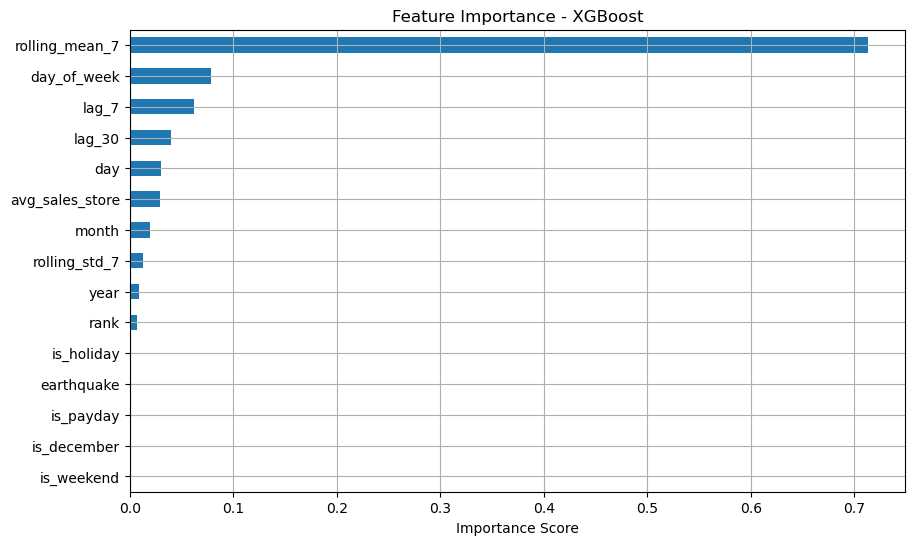

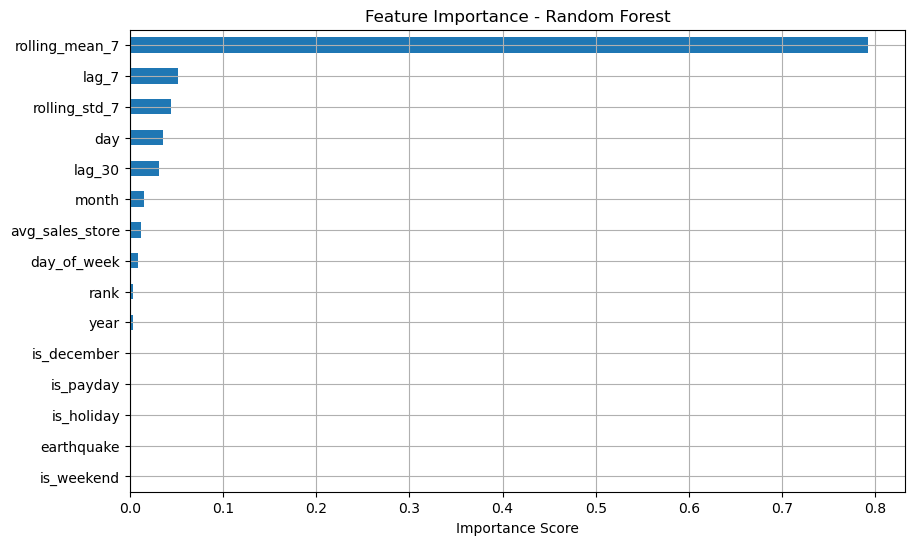

In [16]:
# XGBoost feature importance
xgb_importance = pd.Series(xgb.feature_importances_, index=features)
xgb_importance.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6))
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.grid(True)
plt.show()

# Random Forest feature importance
rf_importance = pd.Series(rf.feature_importances_, index=features)
rf_importance.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6))
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.grid(True)
plt.show()


## Key Insights

##### XGBoost emerged as the best overall model in terms of R² score (0.887) and relatively lower RMSE compared to Random Forest and Naive Forecast. This indicates its strong capability to capture non-linearities and interactions in structured tabular data.

##### Random Forest also performed well with an R² of 0.876, making it a solid alternative, especially when interpretability or training speed is more important.

##### Naive Forecast (7-day lag) gave surprisingly decent performance (R² = 0.727), highlighting the presence of weekly seasonality in the data. However, it lacks adaptability to complex patterns and external factors.

##### LSTM achieved an exceptionally low RMSE, which looks impressive, but:

* The R² is lower than tree-based models.

* MAPE is extremely inflated, likely due to very small actual values or zeros in the validation set - which LSTM may have predicted poorly or overfitted.

* Possible issues in inverse scaling or residuals on a log/small scale.

## External Factors and Their Influence:

##### Holidays: Holidays, particularly major ones, have a significant impact on sales patterns. The presence of holidays was used as a feature in all models. XGBoost and Random Forest captured these patterns better by considering both individual store performance and holiday types, allowing the models to adjust for holiday-driven sales spikes or drops.

* Example: Sales around Christmas or Black Friday would likely see a spike, and XGBoost can capture this trend due to its ability to model complex interactions.

##### Oil Prices: The oil price (dcoilwtico) was incorporated into the model as an external factor. Fluctuating oil prices can affect consumer purchasing behavior due to changes in transportation costs or disposable income.

* Example: A sudden drop in oil prices could increase consumer spending, indirectly boosting sales. XGBoost likely performed well because it could account for this external influence through the oil price feature.

##### Promotions: Though promotions weren't explicitly mentioned in the data, they could be inferred by analyzing spikes or dips in sales around specific dates (e.g., sales around specific holidays or store-specific promotions). XGBoost would have benefited from this implicit understanding, as it can capture patterns from external factors like these.

## Business Strategies for Improving Sales Forecasting:

#### Inventory Planning:

Use XGBoost or Random Forest for more accurate demand forecasts to ensure that inventory levels are optimized for expected sales. This will help in minimizing stockouts and overstock situations, which can reduce costs and improve customer satisfaction.

Promotions & Holidays: Anticipating sales spikes around holidays can lead to better inventory preparation, ensuring that stores have the right products in stock during high-demand periods.

#### Targeted Promotions:

By analyzing sales data around holidays, oil price fluctuations, and specific dates, businesses can tailor promotions more effectively.

Customized Offers: Implement promotions based on store performance and product-specific trends, as identified by models like XGBoost, which can pinpoint the best times to offer discounts and the products that need a promotional push.

#### Dynamic Pricing:

Use sales forecasts to adjust pricing dynamically. For instance, when oil prices are lower, consumers may have more disposable income, which could justify price increases in certain product categories.

Similarly, during holiday seasons or periods with high demand, businesses can use promotions or limited-time discounts to boost sales.

#### Localized Strategies:

Use the cluster and store-level features in the model to develop localized strategies. Sales patterns can differ by region, and understanding these patterns allows businesses to create more effective localized marketing and inventory strategies.

## Conclusion

##### XGBoost is recommended as the final model for deployment due to its strong predictive power and stability.

##### LSTM could be improved with better sequence handling (e.g., longer sequences, more time steps) and feature engineering, but it requires careful preprocessing and tuning.

##### Tree-based models (RF, XGBoost) remain highly effective for retail sales forecasting due to their robustness and ability to handle categorical + continuous variables and missing data.


While XGBoost is the top-performing model, Random Forest also showed strong results, and both models are highly effective in handling complex, non-linear relationships. Incorporating external factors like holidays and oil prices made a noticeable impact on predictions, reinforcing their importance in sales forecasting. Moving forward, businesses can leverage these models to improve inventory management, optimize promotions, and implement dynamic pricing, ultimately leading to better sales forecasting and more informed decision-making.

